In [109]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Declaração de variáveis


In [110]:
num_cobaias = 9
num_pics = 10
pasta_input = 6
input_img = Image.open(f"database/p{pasta_input}_resized/p{pasta_input}_reconhecimento.jpeg").convert('L')


### Conversão das imagens para formação de uma base


In [111]:
base = [Image.open(f'database/p{i}_resized/p{i}_{j}.jpeg').convert('L') 
        for i in range(1, num_cobaias+1) for j in range(1, num_pics+1)]
size = len(base)
X = np.array([base[i].getdata() for i in range(size)])
len(X[0])

10800

### Centrar os dados na média


In [112]:
media = np.mean(X, 0)
phi = X-media

### Cara média


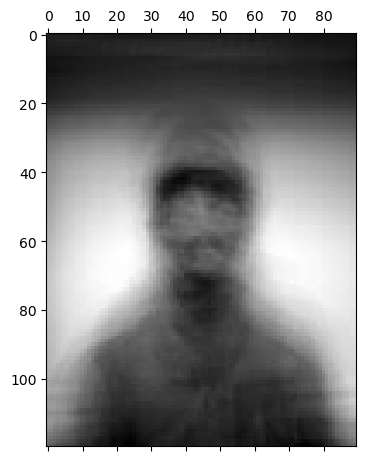

In [113]:
display(plt.matshow(np.reshape(media, (120, 90)), cmap='gray'))

### Aplicar SVD


In [114]:
e_faces, sigma, v = np.linalg.svd(phi.transpose(), full_matrices=False)
val_prop = sigma*sigma
traco = sum(val_prop)
len(val_prop)

90

### Observação dos valores próprios


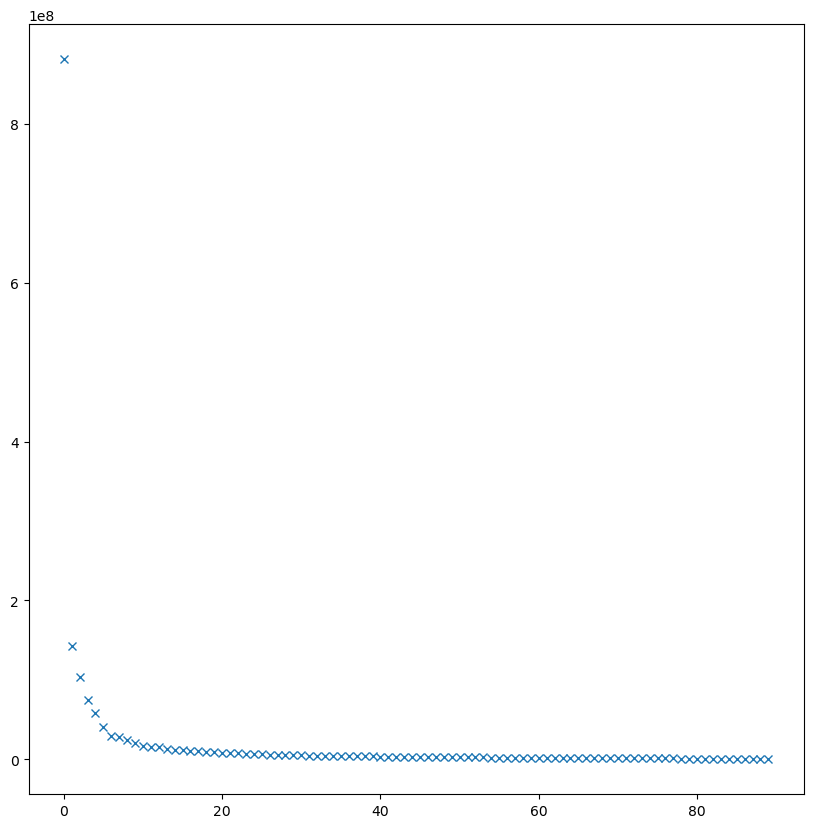

In [115]:
plt.figure(figsize=(10,10))
t = np.arange(0, size, 1)
plt.plot(t, val_prop, 'x')
plt.show()

### Selecionar o valor de K pretendido


In [116]:
'''
k = 0
accuracy = 0
accuracy_wanted = 0.95
while accuracy < accuracy_wanted:
    accuracy = accuracy+val_prop[k]/traco
    k+=1
''' 
k=7
accuracy = sum(val_prop[0:k])/traco    
k, accuracy


(7, 0.7749017526533177)

### Calcular as projeções


In [117]:
coef_proj = [np.dot(phi[i], e_faces[:, 0:k]) for i in range(size)]

### Prediction


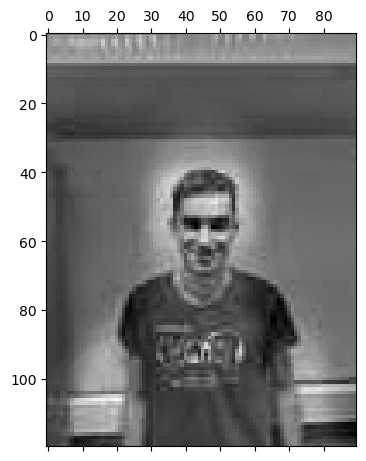

In [118]:
gamma = np.array(input_img.getdata())
test_phi = gamma - media
display(plt.matshow(np.reshape(test_phi, (120,90)), cmap='gray'))

#### MÉTRICA EUCLIDIANA

In [119]:
test_coef_proj = np.dot(test_phi, e_faces[:, 0:k])
dist = [np.linalg.norm(coef_proj[i] - test_coef_proj) for i in range(size)]
d_min = np.min(dist)

In [120]:
if d_min < 7000:
    pasta_rec = np.floor(np.argmin(dist)/10)+1
    print(f'Pasta p{pasta_rec}\ndist={d_min}')
else:
    print('Who the hell are you?')

Pasta p6.0
dist=351.96176821281085


#### MÉTRICA DE MAHALANOBIS

$d(x, y)=\sum \frac{1}{\lambda_i}(x_i-y_i)^2$

In [121]:
def mahalanobis(face1, face2):
    l = []
    
    for i,elem in enumerate(face1-face2):
        l.append((1/val_prop[i])*elem*elem)
    return sum(l)


In [122]:
test_coef_proj = np.dot(test_phi, e_faces[:,0:k])
dist = [mahalanobis(coef_proj[i], test_coef_proj) for i in range(size)]
d_min = np.min(dist)

In [123]:
#if d_min < 7000:
pasta_rec = np.floor(np.argmin(dist)/10)+1
print(f'Pasta p{pasta_rec}\ndist={d_min}')
#else:
    #print('Who the hell are you?')

Pasta p6.0
dist=0.0026637002262447813


#### CICLO PARA VALIDAÇÃO DO MODELO

In [124]:
dic = {}

for i in range(1,num_cobaias+1):
    pasta_input = i
    input_img = Image.open(f"database/p{pasta_input}_resized/p{pasta_input}_reconhecimento.jpeg").convert('L')

    gamma = np.array(input_img.getdata())
    test_phi = gamma - media

    test_coef_proj = np.dot(test_phi, e_faces[:, 0:k])

    dist = [np.linalg.norm(coef_proj[i] - test_coef_proj) for i in range(size)]
    d_min = np.min(dist)
    pasta_rec_eucl = np.floor(np.argmin(dist)/10)+1


    dist = [mahalanobis(coef_proj[i], test_coef_proj) for i in range(size)]
    d_min = np.min(dist)
    pasta_rec_maha = np.floor(np.argmin(dist)/10)+1


    dic[i] = (pasta_rec_eucl, pasta_rec_maha)



print("PASTA INPUT | RECONHECIMENTO C/ DIST. EUCL. | RECONHECIMENTO C/ DIST. MAHA.")
for k in dic:
    print(f"    {int(k)}       |                {int(dic[k][0])}              |                {int(dic[k][1])}")
    


    

    

PASTA INPUT | RECONHECIMENTO C/ DIST. EUCL. | RECONHECIMENTO C/ DIST. MAHA.
    1       |                1              |                1
    2       |                7              |                7
    3       |                3              |                3
    4       |                4              |                4
    5       |                5              |                5
    6       |                6              |                6
    7       |                7              |                7
    8       |                8              |                8
    9       |                9              |                9


### Representação dos dados em 2D


In [125]:
def identify(img):
    gamma = np.array(img.getdata())
    test_phi = gamma - media
    test_coef_proj = np.dot(test_phi, e_faces[:,0:2])
    return test_coef_proj

Text(0, 0.5, 'Eigenface 2')

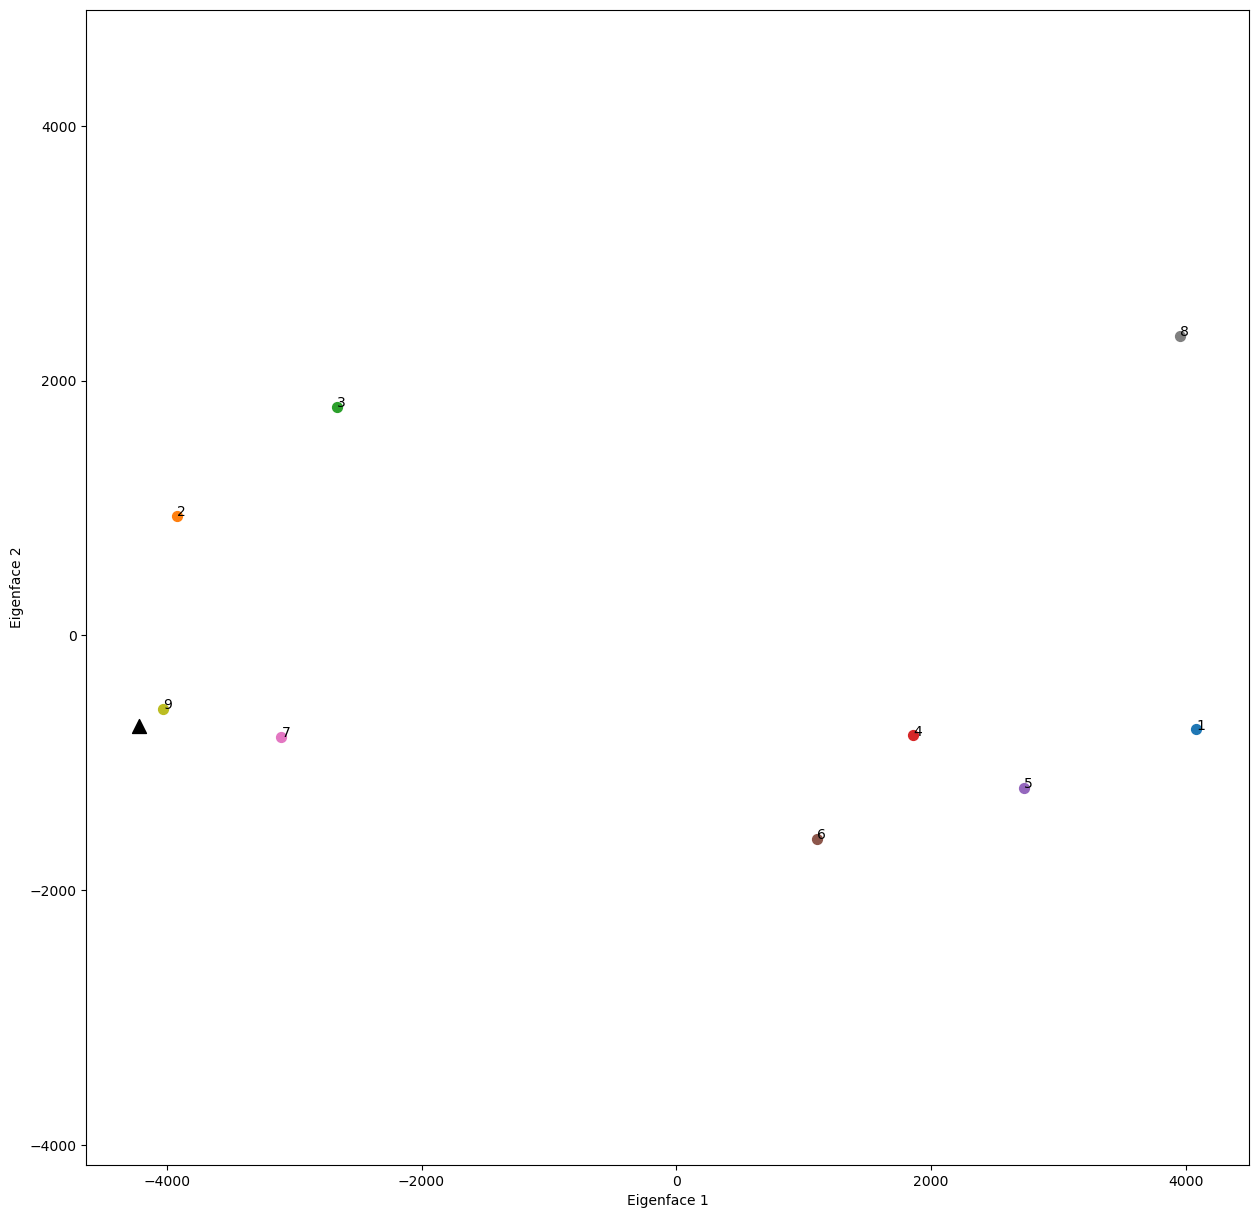

In [126]:
plt.figure(figsize=(15,15))
plt.axis('equal')
for pasta in range(1,num_cobaias+1):
    imagens = [Image.open(f'database/p{pasta}_resized/p{pasta}_{i}.jpeg').convert('L') for i in range(5,6)]
    x, y = np.array([identify(pic) for pic in imagens]).T
    plt.scatter(x,y, s=50)
    plt.text(x, y, pasta)
plt.scatter(*identify(input_img), label='Input image', marker='^', c='k', s=100)
plt.xlabel('Eigenface 1')
plt.ylabel('Eigenface 2')